In [21]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# analysis parameters
data_file = "GECC\ FYP\ Survey.csv"

DRINKING_CONSUMPTION_LIGHT = 1
DRINKING_CONSUMPTION_MEDIUM = 3
DRINKING_CONSUMPTION_HEAVY = 15

In [22]:
# setup dataframe

# read file
df = pd.read_csv(data_file, error_bad_lines=False)

'''
    rename columns to readable format
    activity_1 = join for student club / organization / student union
    activity_2 = exco for student club / organization / student union
'''
df.columns = [
    "time", 
    "gender", 
    "age", 
    "local_or_non_local", 
    "nationality_current", # voided
    "university", 
    "current_study", 
    "year_of_study", 
    "drinking_frequency", 
    "drinking_consumption_amount", 
    "drinking_frequency_six_servings", 
    "type_of_drink",
    "drinking_occasion", 
    "attention_test", 
    "drinking_frequency_before_examination", 
    "gpa", 
    "activity_1", 
    "activity_2", 
    "academic_achievements", 
    "professional_examinations", 
    "nationality_extra" # voided
    # nationality
]

# fix nationality columns
df["nationality"] = df.nationality_current.combine_first(df.nationality_extra)
df.loc[ df["nationality"] == "Malaysian 馬來西亞", "nationality" ] = "Malaysia"
df.loc[ df["nationality"] == "Philippine 菲律賓", "nationality" ] = "Philipine"
df.loc[ df["nationality"] == "Indonesian 印尼", "nationality" ] = "Indonesia"
df.drop(columns=["nationality_current", "nationality_extra"], inplace=True)

# filter based on valid response
df = df.loc[ df["attention_test"] == "Italian 義式" ]
# df = df.loc[ df["gpa"] > 1 ]
df = df.loc[ (df.drinking_consumption_amount == 0) | ~(df.drinking_frequency == "Never 從來不飲用") ]
df = df.loc[ ~(df["university"] == "UCL") ]

# drop unnecessary columns
df.drop(columns=["time", "attention_test"], inplace=True)

df.head()


/opt/anaconda3/envs/gecc-fyp/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


FileNotFoundError: [Errno 2] No such file or directory: 'GECC FYP Survey.csv'

In [3]:
df_non_drinker  = df.loc[ df["drinking_consumption_amount"] == 0]
df_drinker = df.loc[ ~(df["drinking_consumption_amount"] == 0)]
df_light_drinker  = df.loc[ (df["drinking_consumption_amount"] <= DRINKING_CONSUMPTION_LIGHT) & (df["drinking_consumption_amount"] > 0)]
df_medium_drinker = df.loc[ (df["drinking_consumption_amount"] <= DRINKING_CONSUMPTION_MEDIUM) & (df["drinking_consumption_amount"] > DRINKING_CONSUMPTION_LIGHT) ]
df_heavy_drinker  = df.loc[ (df["drinking_consumption_amount"] <= DRINKING_CONSUMPTION_HEAVY) & (df["drinking_consumption_amount"] > DRINKING_CONSUMPTION_MEDIUM) ]

print("Number of non drinker", len(df_non_drinker))
print("Number of drinker", len(df_drinker))
print("Number of light drinker", len(df_light_drinker))
print("Number of medium drinker", len(df_medium_drinker))
print("Number of heavy drinker", len(df_heavy_drinker))

Number of non drinker 30
Number of drinker 119
Number of light drinker 30
Number of medium drinker 46
Number of heavy drinker 43


In [4]:
# general overview drinker vs non drinker

# gender
df_non_drinker_gender = df_non_drinker.groupby("gender").size().reset_index()
df_drinker_gender = df_drinker.groupby("gender").size().reset_index()

print(df_non_drinker_gender)
print()
print(df_drinker_gender)


      gender   0
0  Female 女性  18
1    Male 男性  12

                    gender   0
0                Female 女性  56
1                  Male 男性  60
2  Prefer not to say 不方便透露   3


In [5]:
# year of study
df_non_drinker_year_of_study = df_non_drinker.groupby("year_of_study").size().reset_index()
df_drinker_year_of_study = df_drinker.groupby("year_of_study").size().reset_index()

print(df_non_drinker_gender)
print()
print(df_drinker_gender)

      gender   0
0  Female 女性  18
1    Male 男性  12

                    gender   0
0                Female 女性  56
1                  Male 男性  60
2  Prefer not to say 不方便透露   3


In [6]:
# nationality
df_non_drinker_nationality = df_non_drinker.groupby("nationality").size().reset_index()
df_drinker_nationality = df_drinker.groupby("nationality").size().reset_index()

print(df_non_drinker_nationality)
print()
print(df_drinker_nationality)


  nationality   0
0       China   4
1   Hong Kong  15
2       India   3
3   Indonesia   2
4  Kazakhstan   1
5      Taiwan   1
6    Thailand   4

      nationality   0
0           China   6
1       Hong Kong  49
2           India   3
3       Indonesia  31
4      Kazakhstan   1
5    Korea, South   9
6        Malaysia   2
7       Philipine   1
8          Russia   1
9          Taiwan  14
10  United States   2


# Hypothesis Testing (Drinker vs. Non Drinker) t-Test
Hypothesis testing using z value since sample size is assumed to be large and the level of significance will be 5%

$H_0$: average gpa of drinker and non drinker are similar

$H_1$: average gpa of drinker and non drinker are different

since significance level is 5%, the z-score that is expected to satisfied the null hyphothesis should be $\pm$ 1.96 (two-tailed test critical value), where the z-score can be calculated as follow:

$$
    Z_s = \frac{X-\bar{X}}{\sqrt{\frac{S_1^2}{n_1} + \frac{S_2^2}{n_2}}}
$$

In [7]:
non_drinker_mean_gpa = df_non_drinker["gpa"].replace(0, np.nan).dropna().mean()
non_drinker_std_gpa = df_non_drinker["gpa"].replace(0, np.nan).dropna().std()
non_drinker_size = len(df_non_drinker["gpa"].replace(0, np.nan).dropna())

drinker_mean_gpa = df_drinker["gpa"].replace(0, np.nan).dropna().mean()
drinker_std_gpa = df_drinker["gpa"].replace(0, np.nan).dropna().std()
drinker_size = len(df_drinker["gpa"].replace(0, np.nan).dropna())

z_score_gpa_drink = (non_drinker_mean_gpa - drinker_mean_gpa) / (np.sqrt( non_drinker_std_gpa**2 / non_drinker_size + drinker_std_gpa**2 / drinker_size))
print(z_score_gpa_drink)


2.470538499324589


In [8]:
len(df_drinker) + len(df_non_drinker)

149

result of the z score is 1.541 which is in the range of rejection of null hypothesis. Therefore, we can conclude that we $\bold{cannot}$ reject the null hypothesis

In [9]:
z_score_academic_achievement = (df_non_drinker["academic_achievements"].mean() - df_drinker["academic_achievements"].mean()) / (np.sqrt( df_non_drinker["academic_achievements"].std()**2 / len(df_non_drinker["academic_achievements"]) + df_drinker["academic_achievements"].std()**2 / len(df_drinker["academic_achievements"])))
z_score_professional_examinations = (df_non_drinker["professional_examinations"].mean() - df_drinker["professional_examinations"].mean()) / (np.sqrt( df_non_drinker["professional_examinations"].std()**2 / len(df_non_drinker["professional_examinations"]) + df_drinker["professional_examinations"].std()**2 / len(df_drinker["professional_examinations"])))
print(z_score_academic_achievement)
print(z_score_professional_examinations)

-0.19261115886458482
1.4745599018708597


result of z-score for both academic achievements and professional examinations are within the acceptance range for null hypothesis. Therefore we can conclude that there is no difference between drinkers and non drinkers.

# Hypothesis Testing (Amount of drinks vs. GPA)

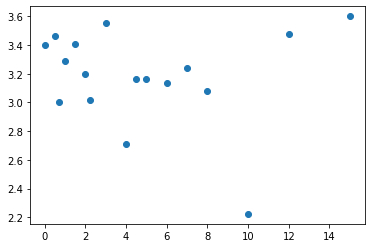

In [10]:
df_drink_amount_average = df_drinker.groupby("drinking_consumption_amount").mean().reset_index()
plt.scatter(df_drink_amount_average["drinking_consumption_amount"], df_drink_amount_average["gpa"])
plt.show()


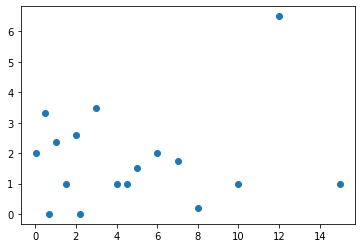

In [11]:
plt.scatter(df_drink_amount_average["drinking_consumption_amount"], df_drink_amount_average["academic_achievements"])
plt.show()

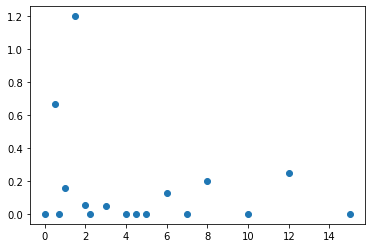

In [12]:
plt.scatter(df_drink_amount_average["drinking_consumption_amount"], df_drink_amount_average["professional_examinations"])
plt.show()

# Quantifying categorical values

In [13]:
df_drinker_quantified = df_drinker

df_drinker_quantified.loc[ df.year_of_study == "4 or above 四年級以上", "year_of_study" ] = 4.0

df_drinker_quantified.loc[ df.drinking_frequency == "Monthly or less 少於每月", "drinking_frequency" ] = 1.0 / 16.0
df_drinker_quantified.loc[ df.drinking_frequency == "Monthly or less 少於一個月", "drinking_frequency" ] = 1.0 / 16.0
df_drinker_quantified.loc[ df.drinking_frequency == "2-4 times a month 每月二至四次", "drinking_frequency" ] = 3.0 / 16.0
df_drinker_quantified.loc[ df.drinking_frequency == "2-3 times a week 每週二至三次", "drinking_frequency" ] = 10.0 / 16.0
df_drinker_quantified.loc[ df.drinking_frequency == "4 or more times a week 每週四次以上", "drinking_frequency" ] = 16.0 / 16.0

df_drinker_quantified.loc[ df.drinking_frequency_six_servings == "Daily or almost daily 每天或幾乎每天", "drinking_frequency_six_servings" ] = 30.0 / 30.0
df_drinker_quantified.loc[ df.drinking_frequency_six_servings == "Weekly 每週", "drinking_frequency_six_servings" ] = 4.0 / 30.0
df_drinker_quantified.loc[ df.drinking_frequency_six_servings == "Monthly 每月", "drinking_frequency_six_servings" ] = 1.0 / 30.0
df_drinker_quantified.loc[ df.drinking_frequency_six_servings == "Less than once per month 少於每月", "drinking_frequency_six_servings" ] = .5 / 30.0
df_drinker_quantified.loc[ df.drinking_frequency_six_servings == "Less than once per month 少於一個月", "drinking_frequency_six_servings" ] = .5 / 30.0
df_drinker_quantified.loc[ df.drinking_frequency_six_servings == "Never 從來不會", "drinking_frequency_six_servings" ] = 0.0 / 30.0

df_drinker_quantified.loc[ df.drinking_frequency_before_examination == "Never (0%) 從來不會", "drinking_frequency_before_examination" ] = 0.0 / 10.0
df_drinker_quantified.loc[ df.drinking_frequency_before_examination == "Occasionally (20%) 偶爾", "drinking_frequency_before_examination" ] = 2.0 / 10.0
df_drinker_quantified.loc[ df.drinking_frequency_before_examination == "Sometimes (40%) 有時", "drinking_frequency_before_examination" ] = 4.0 / 10.0
df_drinker_quantified.loc[ df.drinking_frequency_before_examination == "Often (60%) 經常", "drinking_frequency_before_examination" ] = 6.0 / 10.0
df_drinker_quantified.loc[ df.drinking_frequency_before_examination == "Usually (80%) 通常", "drinking_frequency_before_examination" ] = 8.0 / 10.0
df_drinker_quantified.loc[ df.drinking_frequency_before_examination == "Always (100%) 總是", "drinking_frequency_before_examination" ] = 10.0 / 10.0

df_drinker_quantified.loc[ df_drinker_quantified.activity_1 == "Yes 有", "activity_1" ] = 1.0
df_drinker_quantified.loc[ df_drinker_quantified.activity_1 == "No 沒有", "activity_1" ] = 0

df_drinker_quantified.loc[ df_drinker_quantified.activity_2 == "Yes 有", "activity_2" ] = 1.0
df_drinker_quantified.loc[ df_drinker_quantified.activity_2 == "No 沒有", "activity_2" ] = 0

quantified_columns = ["year_of_study", "drinking_frequency", "drinking_consumption_amount", "drinking_frequency_six_servings", "gpa", "activity_1", "activity_2", "academic_achievements", "professional_examinations"]

df_drinker_quantified = df_drinker_quantified[quantified_columns]

/opt/anaconda3/envs/gecc-fyp/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [14]:
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler 

# X_scaler = StandardScaler()

# # selected attribute
# attribute = ["year_of_study", "drinking_frequency", "drinking_consumption_amount", "drinking_frequency_six_servings", "gpa"]
# X_train_scaled_attribute = X_scaler.fit_transform(df_drinker_quantified[attribute]) 
# df_drinker_quantified[attribute] = X_train_scaled_attribute

# x_att = df_drinker_quantified[attribute[:-1]]
# y_att = df_drinker_quantified[attribute[-1]]

# x_att_1 = np.array(x_att[attribute[0]])
# x_att_2 = np.array(x_att[attribute[1]])
# x_att_3 = np.array(x_att[attribute[2]])
# x_att_4 = np.array(x_att[attribute[3]])

# y_att_final = np.array(y_att)
# n = len(y_att_final)

# x_bias = np.ones((n, 1))

# x_att_1_reshape = np.reshape(x_att_1, (n, 1))
# x_att_2_reshape = np.reshape(x_att_2, (n, 1))
# x_att_3_reshape = np.reshape(x_att_3, (n, 1))
# x_att_4_reshape = np.reshape(x_att_4, (n, 1))

# x_att_final = np.append(x_bias, x_att_1_reshape, axis=1)
# x_att_final = np.append(x_att_final, x_att_2_reshape, axis=1)
# x_att_final = np.append(x_att_final, x_att_3_reshape, axis=1)
# x_prime = np.append(x_att_final, x_att_4_reshape, axis=1)

# x_prime_transpose = np.transpose(x_prime)

# theta = np.linalg.inv(x_prime_transpose.dot(x_prime)).dot(x_prime_transpose).dot(y_att_final)
# print("Parameter theta calculated by normal equation:", theta)

'''
pca_tested_label = ["year_of_study", "drinking_frequency", "drinking_consumption_amount", "drinking_frequency_six_servings", "gpa"]

pca = PCA()
pca.fit(df_drinker_quantified[pca_tested_label])
print(pca_tested_label)
print(pca.explained_variance_ratio_ * 100)
'''

# lin_regr = linear_model.LinearRegression()
# lin_regr.fit(df_drinker_quantified.drop(["gpa", "activity_1", "activity_2", "academic_achievements", "professional_examinations"], axis=1), df_drinker_quantified["gpa"])
# print(lin_regr.coef_)

# fig, axs = plt.subplots(2)
# axs[0].plot(["year_of_study", "drinking_frequency", "drinking_consumption_amount", "drinking_frequency_six_servings"], pca.explained_variance_ratio_)
# axs[0].xticks(rotation=45, ha="right")
# axs[1].plot(["year_of_study", "drinking_frequency", "drinking_consumption_amount", "drinking_frequency_six_servings"], lin_regr.coef_)
# axs[1].xticks(rotation=45, ha="right")

'''
plt.plot(["year_of_study", "drinking_frequency", "drinking_consumption_amount", "drinking_frequency_six_servings", "gpa"], pca.explained_variance_ratio_)
plt.title("Factor of attribute affecting GPA")
plt.ylabel("Factor")
plt.xlabel("Attribute")
plt.xticks(rotation=45, ha="right")

plt.show()
'''
df_drinker_quantified.year_of_study = pd.to_numeric(df_drinker_quantified.year_of_study)
df_drinker_quantified.drinking_frequency = pd.to_numeric(df_drinker_quantified.drinking_frequency)
df_drinker_quantified.drinking_frequency_six_servings = pd.to_numeric(df_drinker_quantified.drinking_frequency_six_servings)
df_drinker_quantified.activity_1 = pd.to_numeric(df_drinker_quantified.activity_1)
df_drinker_quantified.activity_2 = pd.to_numeric(df_drinker_quantified.activity_2)

attribute_correlation = df_drinker_quantified.corr(method='pearson')


/opt/anaconda3/envs/gecc-fyp/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [15]:
attribute_correlation.gpa

year_of_study                      0.211493
drinking_frequency                -0.010672
drinking_consumption_amount       -0.103791
drinking_frequency_six_servings   -0.022116
gpa                                1.000000
activity_1                         0.302063
activity_2                         0.150604
academic_achievements              0.334816
professional_examinations          0.010046
Name: gpa, dtype: float64

2.822815019549346
[ 0.16463418 -0.00047803 -0.02634355 -0.20059996]


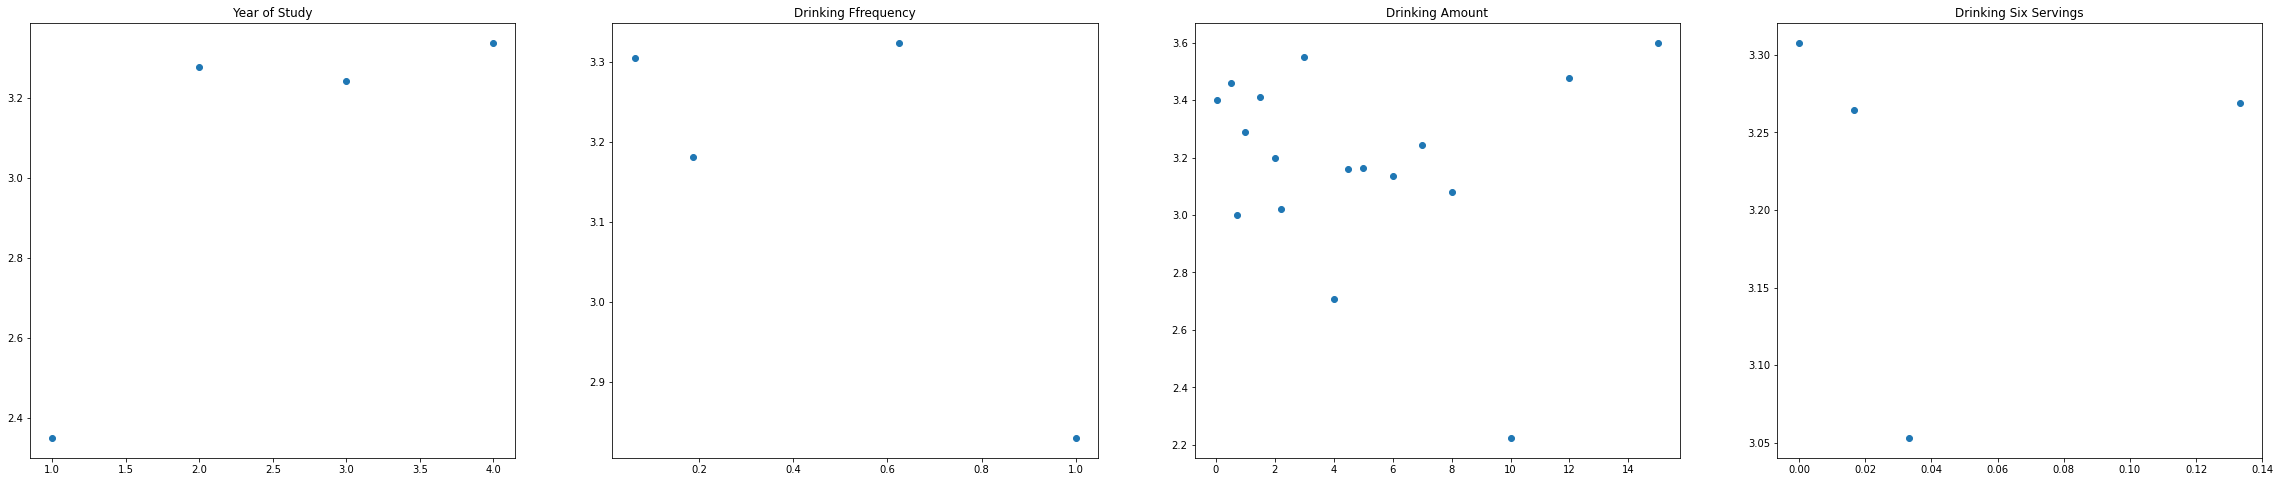

In [16]:
df_drinker_quantified_normalized = (df_drinker_quantified - df_drinker_quantified.min()) / (df_drinker_quantified.max() - df_drinker_quantified.min())

x_columns = ["year_of_study", "drinking_frequency", "drinking_consumption_amount", "drinking_frequency_six_servings"]

# gpa
linear_regression_gpa = linear_model.LinearRegression()
linear_regression_gpa.fit(df_drinker_quantified[x_columns], df_drinker_quantified["gpa"])
print(linear_regression_gpa.intercept_)
print(linear_regression_gpa.coef_)

plt.figure(figsize=(40, 8))

gpa_group_by_year = df_drinker_quantified[["year_of_study", "gpa"]].groupby("year_of_study").mean().reset_index()
plt_year = plt.subplot(1, 4, 1) 
plt_year = plt.scatter(gpa_group_by_year["year_of_study"], gpa_group_by_year["gpa"])
plt.title("Year of Study")

# freq
gpa_group_by_freq = df_drinker_quantified[["drinking_frequency", "gpa"]].groupby("drinking_frequency").mean().reset_index()
plt_freq = plt.subplot(1, 4, 2) 
plt_freq = plt.scatter(gpa_group_by_freq["drinking_frequency"], gpa_group_by_freq["gpa"])
plt.title("Drinking Ffrequency")

# amount
gpa_group_by_amount = df_drinker_quantified[["drinking_consumption_amount", "gpa"]].groupby("drinking_consumption_amount").mean().reset_index()
plt_amount = plt.subplot(1, 4, 3) 
plt_amount = plt.scatter(gpa_group_by_amount["drinking_consumption_amount"], gpa_group_by_amount["gpa"])
plt.title("Drinking Amount")


# drinking_frequency_six_servings
gpa_group_by_six_servings = df_drinker_quantified[["drinking_frequency_six_servings", "gpa"]].groupby("drinking_frequency_six_servings").mean().reset_index()
plt_six_servings = plt.subplot(1, 4, 4) 
plt_six_servings = plt.scatter(gpa_group_by_six_servings["drinking_frequency_six_servings"], gpa_group_by_six_servings["gpa"])
plt.title("Drinking Six Servings")

plt.show()

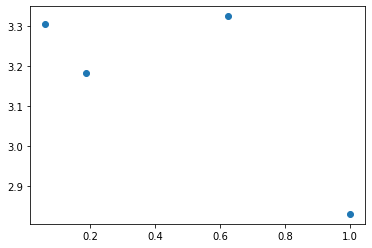

In [17]:
df_drinking_frequency_average = df_drinker_quantified[["drinking_frequency", "gpa"]].groupby("drinking_frequency").mean().reset_index()
plt.scatter(df_drinking_frequency_average["drinking_frequency"], df_drinking_frequency_average["gpa"])
plt.show()

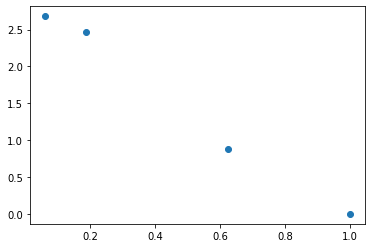

In [18]:
df_frequency = df_drinker_quantified[["drinking_frequency", "academic_achievements"]].groupby("drinking_frequency").mean().reset_index()
plt.scatter(df_frequency["drinking_frequency"], df_frequency["academic_achievements"])
plt.show()

In [19]:
print(df_non_drinker["gpa"].replace(0, np.nan).mean())
print(df_drinker["gpa"].replace(0, np.nan).mean())

3.5049259259259262
3.333293103448275


In [20]:
attribute_correlation

,year_of_study,drinking_frequency,drinking_consumption_amount,drinking_frequency_six_servings,gpa,activity_1,activity_2,academic_achievements,professional_examinations
year_of_study,1.000000,0.074738,0.076195,0.137996,0.211493,0.196042,0.110196,0.121840,0.189892
drinking_frequency,0.074738,1.000000,0.166279,0.681748,-0.010672,-0.046159,-0.154973,-0.167201,-0.083746
drinking_consumption_amount,0.076195,0.166279,1.000000,0.354189,-0.103791,-0.014904,-0.029360,0.009540,-0.070847
drinking_frequency_six_servings,0.137996,0.681748,0.354189,1.000000,-0.022116,0.058094,-0.135028,-0.125847,-0.015111
gpa,0.211493,-0.010672,-0.103791,-0.022116,1.000000,0.302063,0.150604,0.334816,0.010046
activity_1,0.196042,-0.046159,-0.014904,0.058094,0.302063,1.000000,0.511811,0.269322,0.041151
activity_2,0.110196,-0.154973,-0.029360,-0.135028,0.150604,0.511811,1.000000,0.212142,0.054340
academic_achievements,0.121840,-0.167201,0.009540,-0.125847,0.334816,0.269322,0.212142,1.000000,0.077347
professional_examinations,0.189892,-0.083746,-0.070847,-0.015111,0.010046,0.041151,0.054340,0.077347,1.000000
